# Density mask for water masses


The density layers associated with the Circumpolar Deep Waters (CDW) and other water masses can change significantly along the 1 km isobath and along time, appearing and dissapearing in time-space. This high variability can artificially affect the correlations between the Cross Slope Heat Transport and the Antarctic Slope Current speed. In orther to avoid that problem, here we will define our CDW based on density layers that change along space and time.

In [1]:
import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
from gsw import f as fcori
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 

import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
import cf_xarray as cfxr
from xhistogram.xarray import histogram
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
from dask.distributed import Client
client = Client(n_workers=28,memory_limit='190gb') #,memory_limit='190gb'

In [3]:
%%time
CSHT_rho_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
U_along_rho_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho/*')


CPU times: user 31.2 s, sys: 6.18 s, total: 37.4 s
Wall time: 41.5 s


In [4]:
CSHTtotal = CSHT_rho_bins.binned_cross_slope_heat_trans #+CSHT_rho_bins.zonal_convergence+

In [ ]:
warnings. filterwarnings('ignore')
###### T-GRID ######

# Create an empty DataArray with the same shape as 'temp_avg'
full_CSHT_total = xr.full_like(CSHTtotal, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_CSHT_total.data = np.broadcast_to(full_CSHT_total.potrho0.values[np.newaxis, :, np.newaxis], full_CSHT_total.shape)
full_CSHT_total_masked = full_CSHT_total*CSHTtotal/CSHTtotal # Here, we mask by temp_avg to ensure the Nans are preserved 

# Now 'full_st_ocean_t_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yt_ocean and xt_ocean
# and masked by temp_avg

# Find the bottom depth for each (yt_ocean, xt_ocean) coordinate
max_rho = full_CSHT_total_masked.max(dim='potrho0').compute().rename('max_rho')
min_rho = full_CSHT_total_masked.min(dim='potrho0').compute().rename('min_rho')

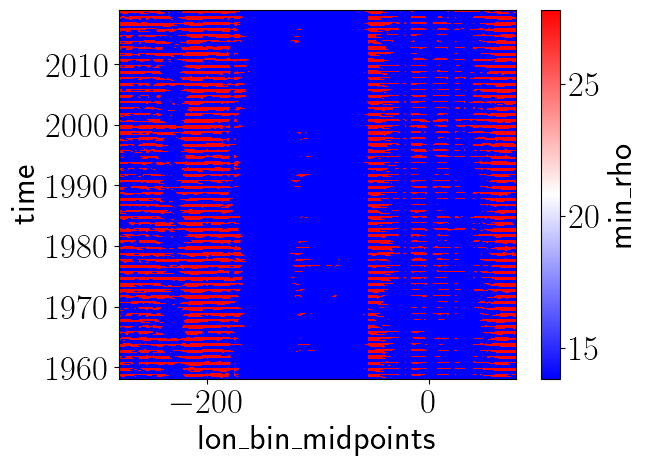

In [7]:
min_rho.plot(cmap=plt.cm.bwr)

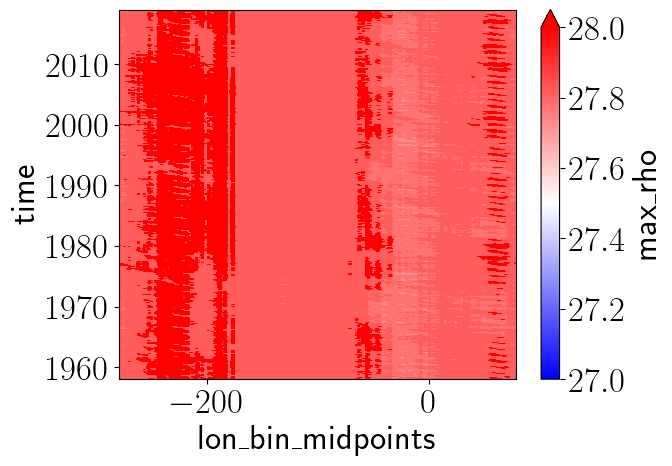

In [8]:
max_rho.plot(vmin=27, vmax=28, cmap=plt.cm.bwr)

## Defining layers for the water masses

What is the minimum value found on the maximum contour? That will define our densesr CDW limit

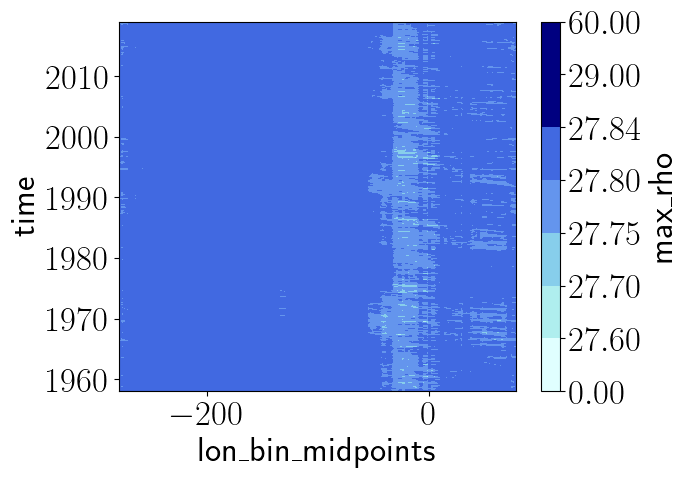

In [108]:
#defining the maximum CDW bins. Whenever the values are bigger or equal to 27.8, 
#we will maintain that as the maximum level
CDW_rho = max_rho
CDW_rhomax = ((CDW_rho.where(CDW_rho>=27.8) * 0)+27.82)


#in case the 27.8 layer does not exist
CDW_rho2 = CDW_rho.where(CDW_rho<27.8).where(CDW_rho>=27.75)
#in case the 27.75 layer does not exist
CDW_rho3 = CDW_rho.where(CDW_rho<27.75).where(CDW_rho>=27.7)
#in case the 27.7 layer does not exist
CDW_rho4 = CDW_rho.where(CDW_rho<27.7).where(CDW_rho>=27.6)

#maximum density limit along time will be:
#CDW_denselimit = CDW_rhomax.fillna(0) + CDW_rhomin.fillna(0)
CDW_denselimit = CDW_rhomax.fillna(0) + CDW_rho2.fillna(0) \
+ CDW_rho3.fillna(0) + CDW_rho4.fillna(0)


levels = [0,27.6,27.7,27.75,27.8,27.84,29,60]

CDW_denselimit.plot.pcolormesh(levels=levels,\
                               colors=['lightcyan','paleturquoise','skyblue','cornflowerblue',\
                                       'royalblue','navy','navy'])




We need to define the lower limit of density for the CDW. I will define it as the density level just above the maximum one. This might however be a problem because by that definition, CDW would go all the way to the surface in some cases.... Is that resonable?

### Circumpolar Deep Water (CDW) definition

Previous analysis of TS diagrams along the isobath show that along most of the 1km isobath, the density range of $27.8\ kg\ m^{-3}\ <\ \sigma_0 \ < \ 27.84 \  kg\ m^{-3}\ $ can often be associated with the **CDW**. However, often this density layer vanishes (spatially and along the time), so we have to make a time-space dependent density definition.


We will define the CDW as:

- **If the density layer $27.8\ kg\ m^{-3}\ <\ \sigma_0 \ < \ 27.84 \  kg\ m^{-3}\ $ exist**, this will be the CDW.
- **If the density layer $27.8\ kg\ m^{-3}\ <\ \sigma_0 \ < \ 27.84 \  kg\ m^{-3}\ $ does <font color='red'>not</font> exist**, we will define CDW as the exhisting density layer right above it. For example, $27.75\ kg\ m^{-3}\ <\ \sigma_0 \ < \ 27.8 \  kg\ m^{-3}\ $

In [118]:
#first lest create a full 3darray, with the standard CDW levels
sigma_values =  ((CSHTtotal*0) + 1) * CSHTtotal.potrho0

CDW_mask = sigma_values.where((sigma_values<=(CDW_denselimit+0.001)))
CDW_mask = CDW_mask.where((sigma_values>=(CDW_denselimit-0.001)))
CDW_mask = (CDW_mask*0)+1


In [119]:
figpath='/g/data/x77/wf4500/ASC_project/analysis_figs/'

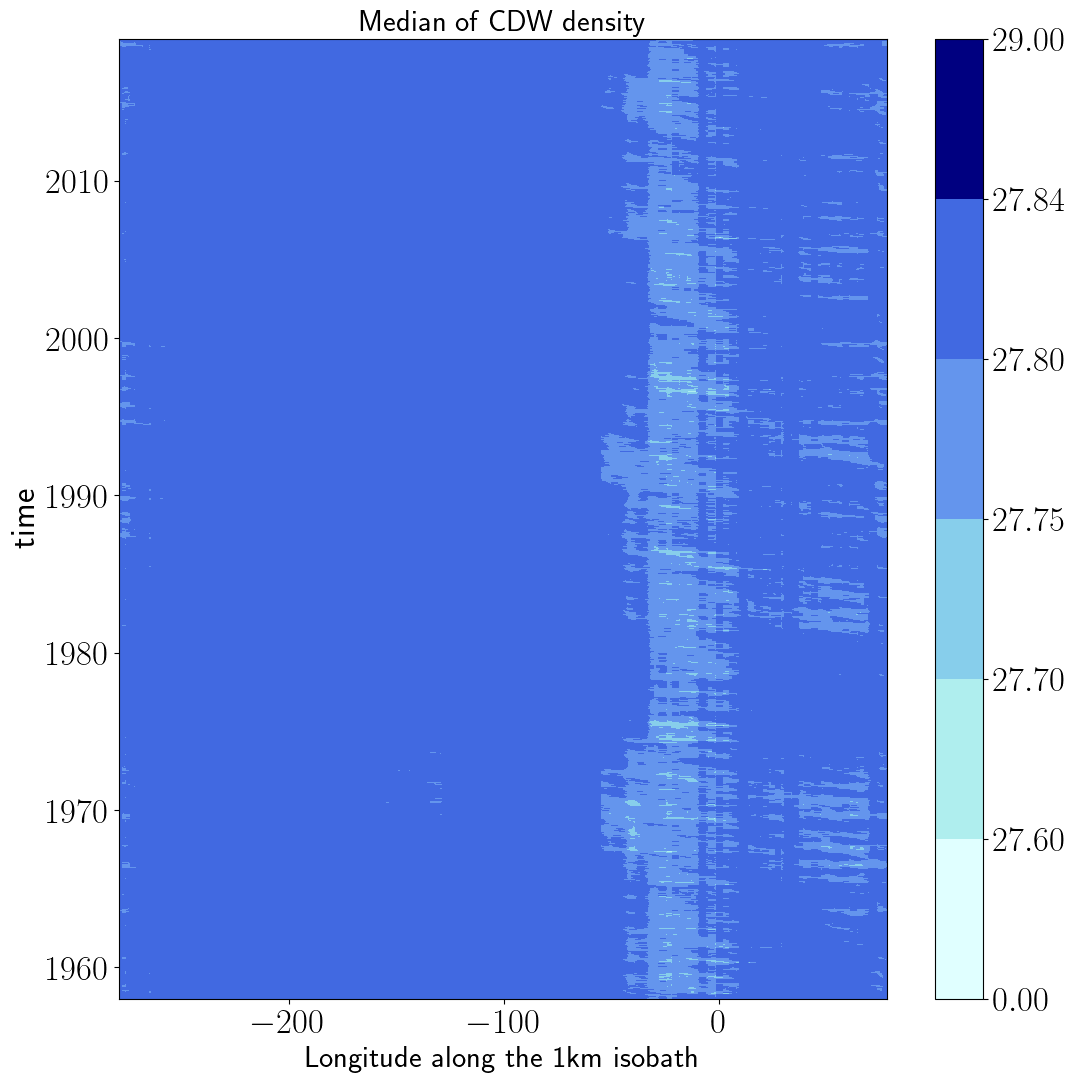

In [128]:
figure = plt.figure(num = 1, figsize = (12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.6)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]


(CDW_mask * sigma_values).median('potrho0').plot.pcolormesh(levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.title('Median of CDW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)

plt.savefig(figpath +'CDWmean_densities_along_time.png',dpi=300)

### Antarctic Surface Waters (AASW) definition

We will define the AASW as the layer right above the CDW,integrated up to the surface. That means that:

- **Most of the time and along most of the isobath**, our AASW will have $ \sigma_0 \ < \ 27.8 \  kg\ m^{-3}\ $.
- **In locations where CDW is lighter** (such as inner Weddell Sea), AASW will mostly have $ \sigma_0 \ < \ 27.75 \  kg\ m^{-3}\ $ , with the densest treshold being even lighter sometimes
- The number of density bins of AASW varies along the time, with more (less) bins whenever CDW is denser (lighter)

In [139]:
AASW_mask = (sigma_values.where((sigma_values<(CDW_denselimit)))*0)+1

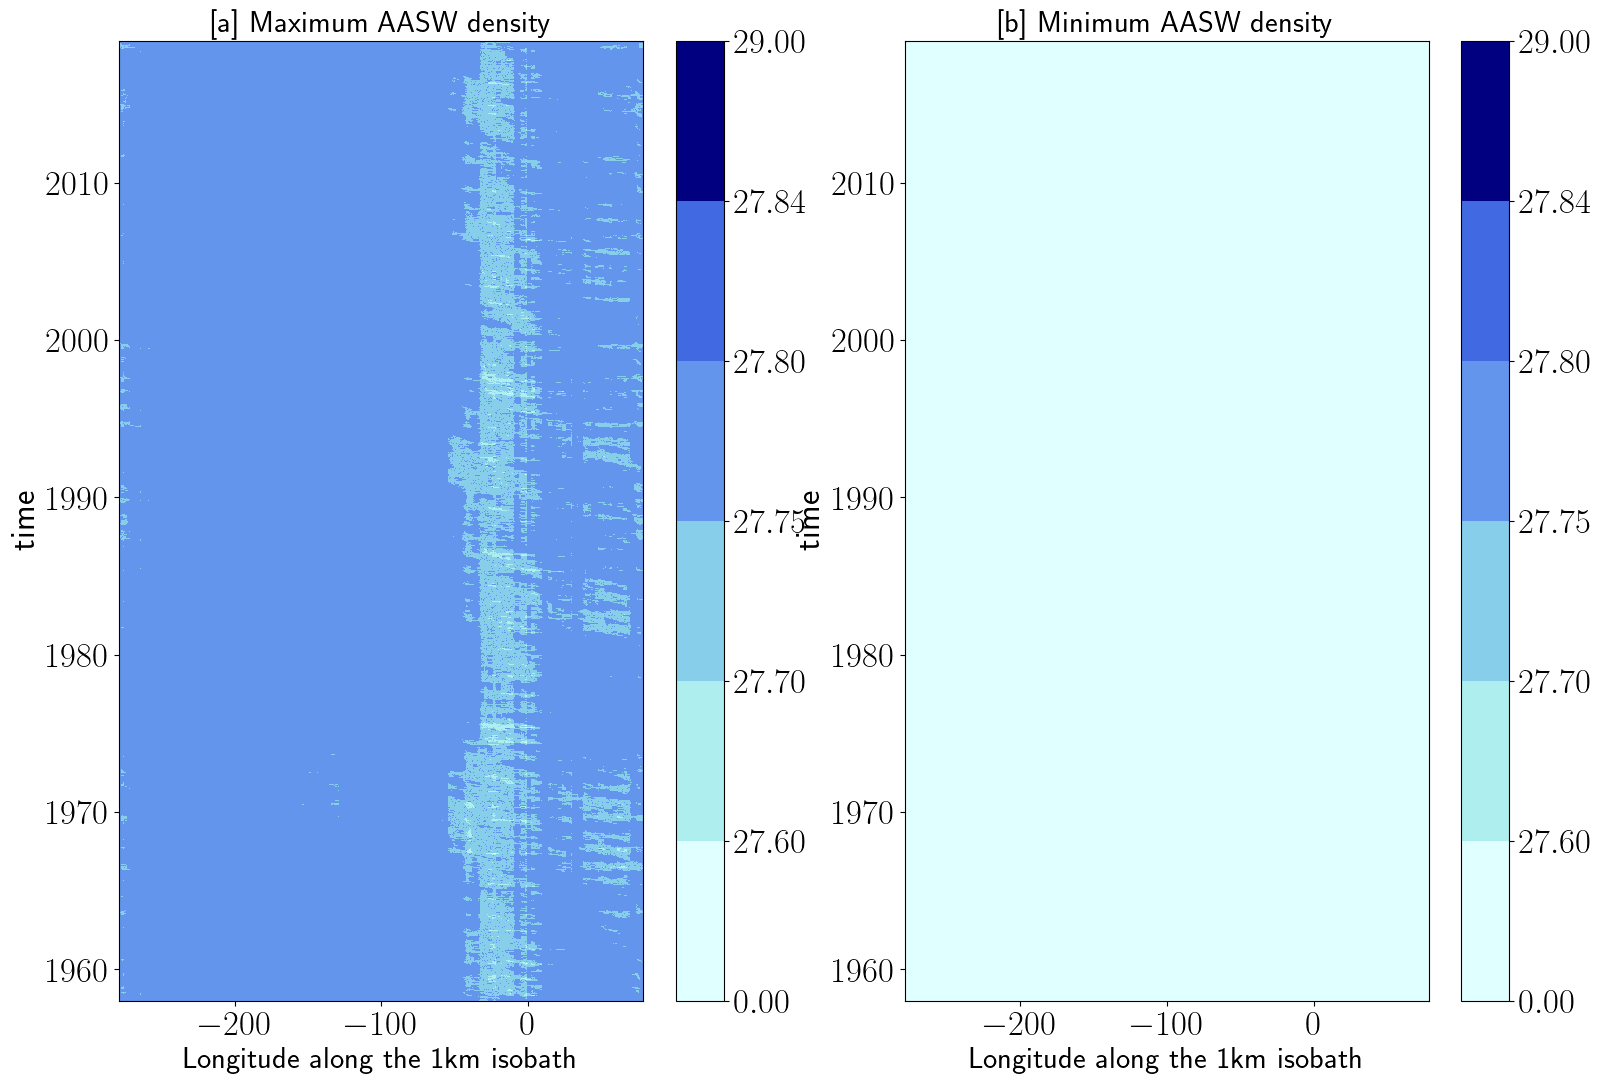

In [140]:
#sanity check on AASW density
figure = plt.figure(num = 1, figsize = (18, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)

plt.subplot(1,2,1)
(AASW_mask * sigma_values).max('potrho0').plot.pcolormesh(levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.title('[a] Maximum AASW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)

plt.subplot(1,2,2)
(AASW_mask * sigma_values).min('potrho0').plot.pcolormesh(levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.title('[b] Minimum AASW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)
plt.savefig(figpath +'AASW_densities_along_time.png',dpi=300)

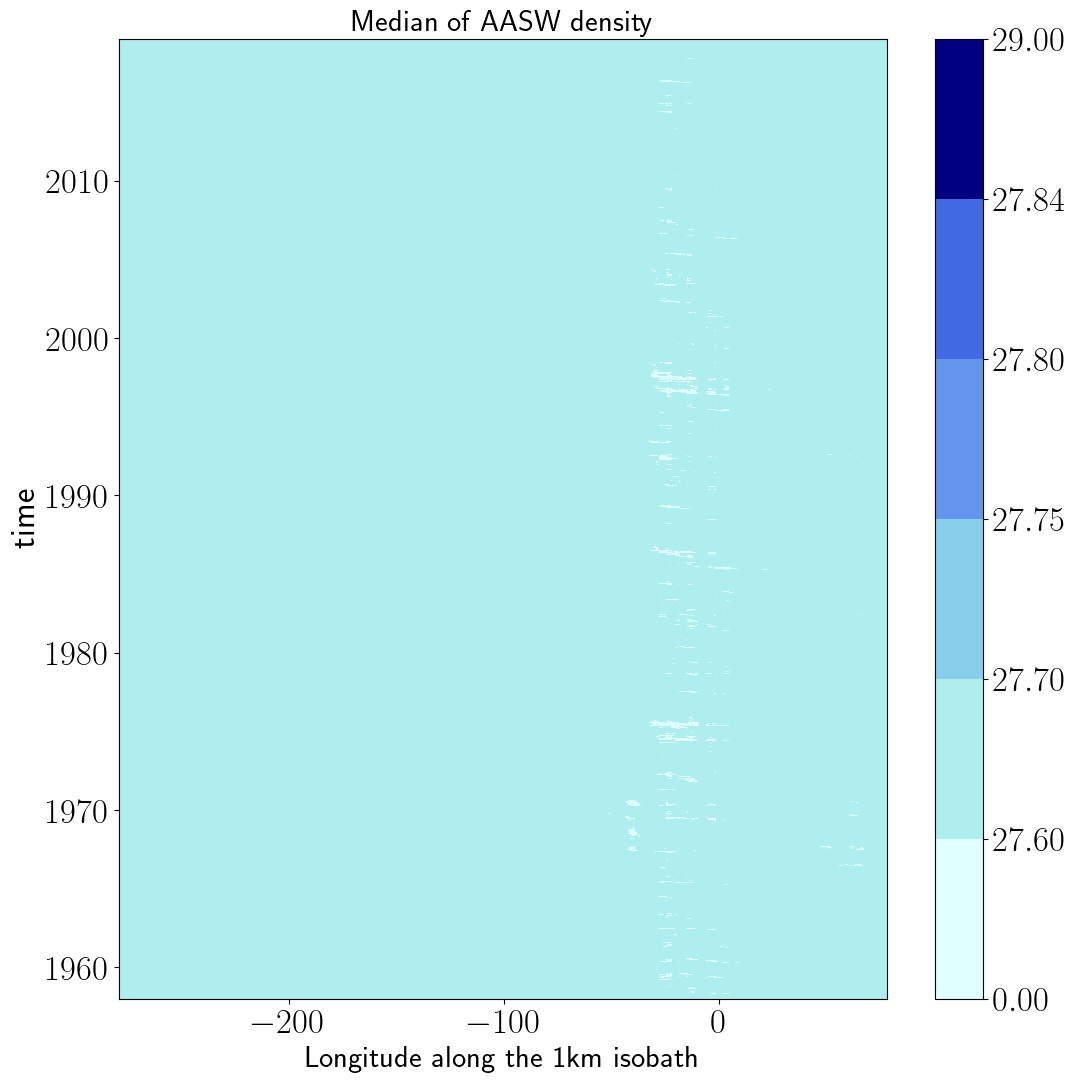

In [141]:
figure = plt.figure(num = 1, figsize = (12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.6)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]


(AASW_mask * sigma_values).median('potrho0').plot.pcolormesh(levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.title('Median of AASW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)
plt.savefig(figpath +'AASWmean_densities_along_time.png',dpi=300)

## Dense Shelf Water (DSW) definition

We will define the DSW as the layer right below the CDW,integrated down to the bottom. That means that:

- Our DSW will always have $ \sigma_0 >27.84\ kg\ m^{-3}\  $.
- **In locations and times that CDW is lighter and this ligther densities reaches the ocean floor**, there will be no DSW

In [161]:
#DSW_mask = (sigma_values.where((sigma_values>=(CDW_denselimit)))*0)+1
DSW_mask = sigma_values.where(sigma_values>=27.84) #setting the density
DSW_mask2 = DSW_mask.where(CSHTtotal!=0)  #filtering where there is data


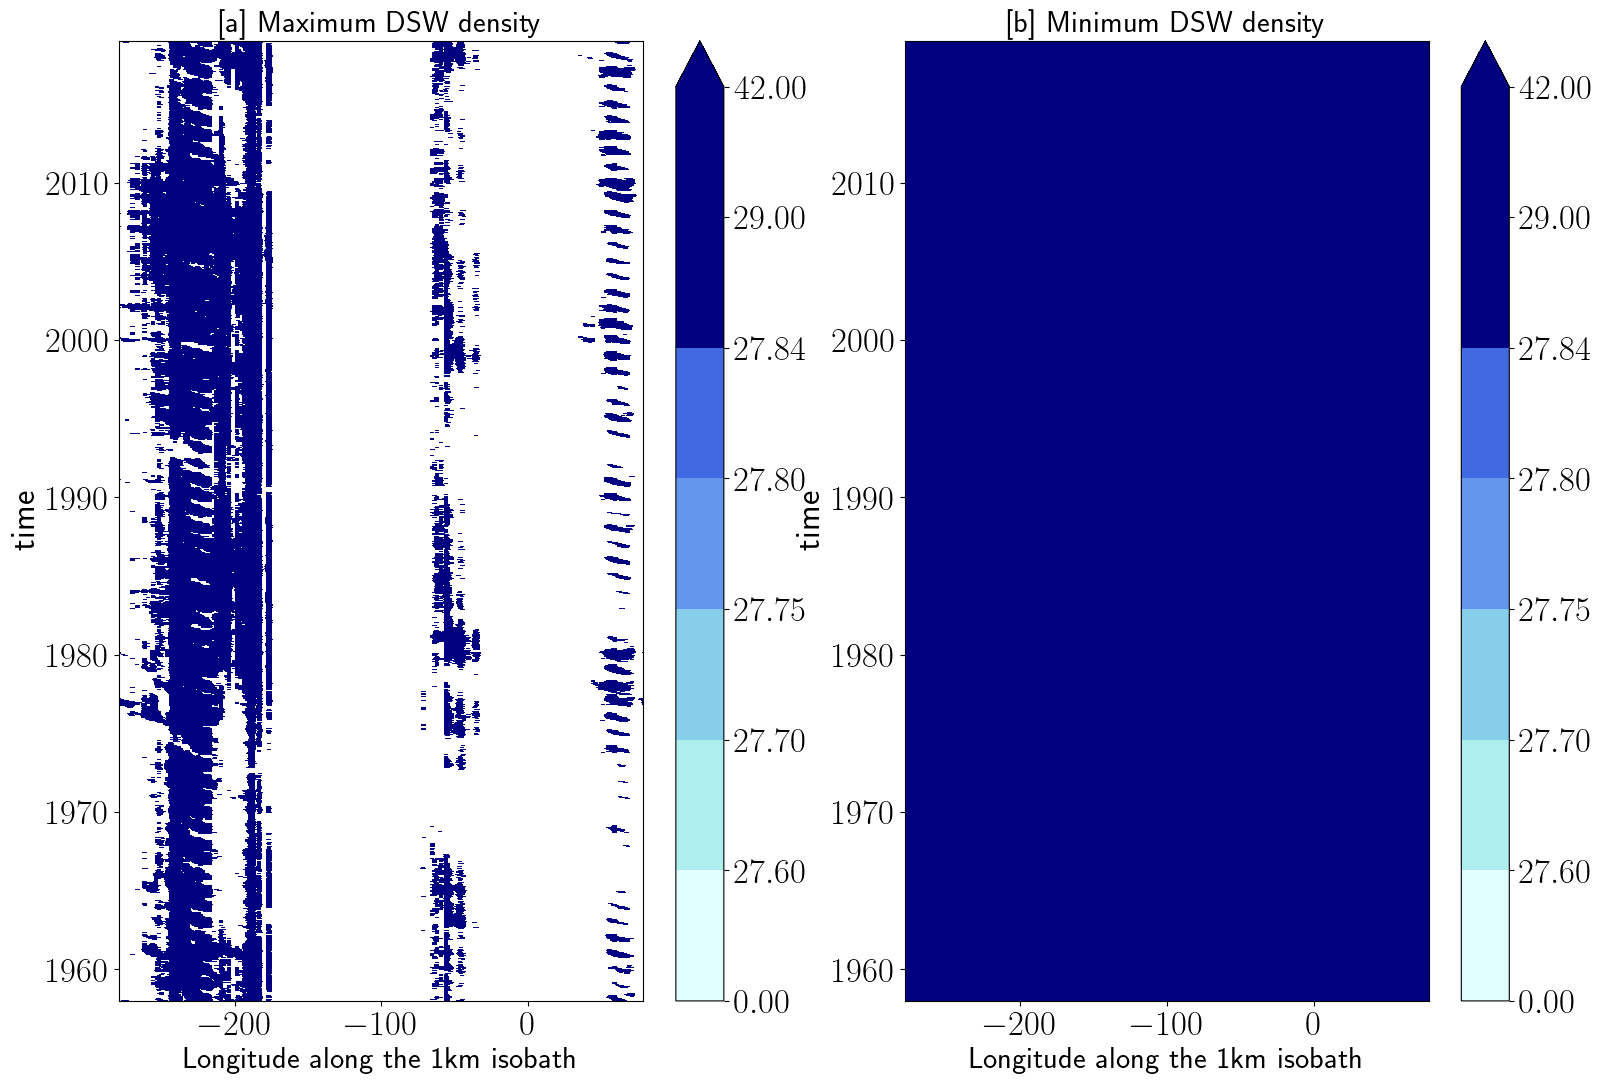

In [162]:
#sanity check on DSW density
figure = plt.figure(num = 1, figsize = (18, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)
levels2 = [0,27.6,27.7,27.75,27.8,27.84,29]

plt.subplot(1,2,1)
(DSW_mask2 * sigma_values).max('potrho0').plot.pcolormesh(levels=levels2,\
                                              colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy','navy','navy']\
                                             ,extend='max')
plt.title('[a] Median of DSW density (masked where',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)

plt.subplot(1,2,2)
(DSW_mask * sigma_values).min('potrho0').plot.pcolormesh(levels=levels2,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy','navy','navy'])
plt.title('[b] Minimum DSW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)
plt.savefig(figpath +'DSW_densities_along_time.png',dpi=300)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-

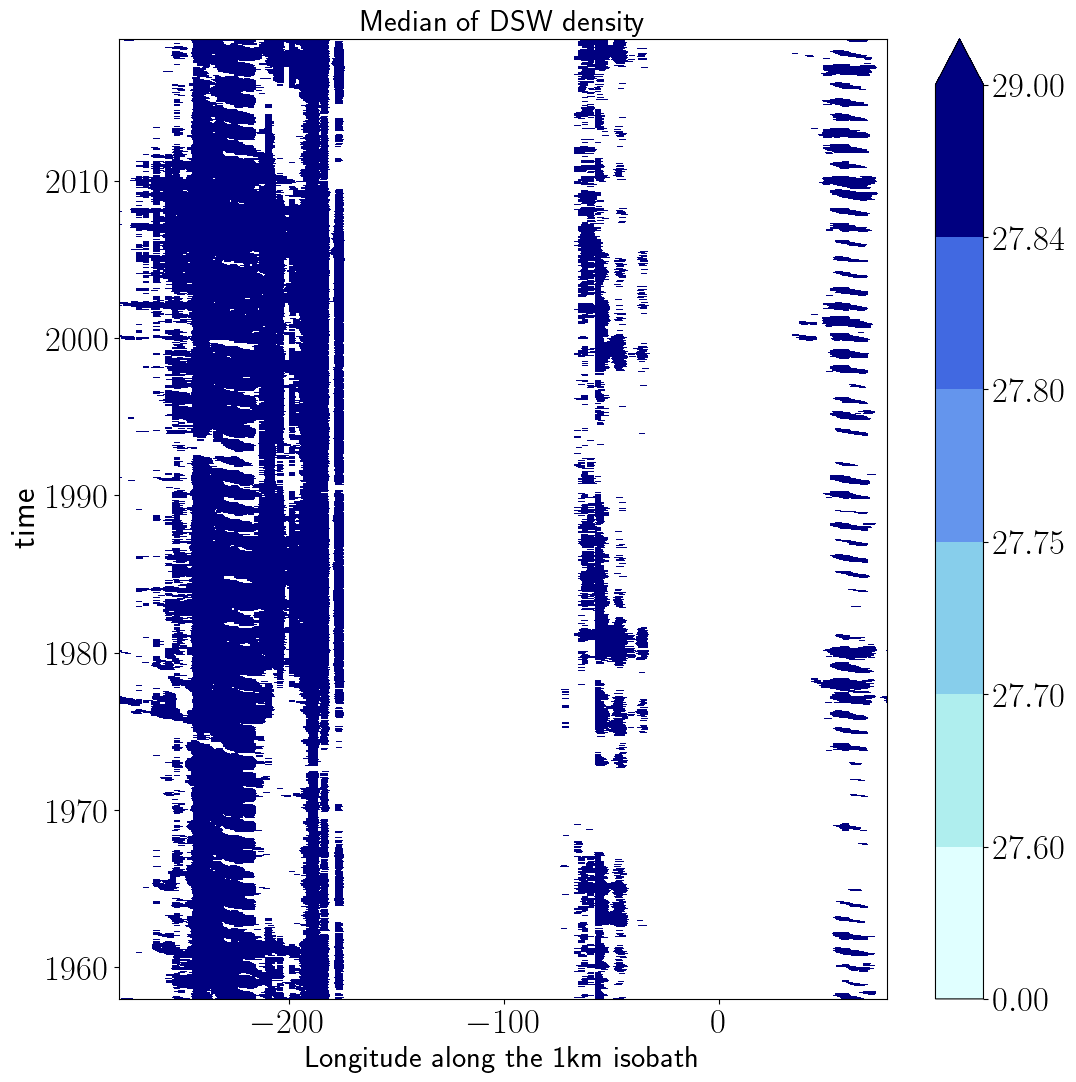

In [167]:
#sanity check on DSW density
figure = plt.figure(num = 1, figsize = (12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)
levels2 = [0,27.6,27.7,27.75,27.8,27.84,29]

(DSW_mask2 * sigma_values).median('potrho0').plot.pcolormesh(levels=levels2,\
                                              colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy','navy']\
                                             ,extend='max')
plt.title('Median of DSW density',fontsize=22);
plt.xlabel('Longitude along the 1km isobath',fontsize=22)


plt.savefig(figpath +'DSWmean_densities_along_time.png',dpi=300)

In [164]:
#saving masks
CDW_mask.name = 'CDW mask'
CDW_mask.to_netcdf('/g/data/v45/wf4500/ASC_project_files/CDW_mask.nc')

AASW_mask.name = 'AASW mask'
AASW_mask.to_netcdf('/g/data/v45/wf4500/ASC_project_files/AASW_mask.nc')

DSW_mask.name = 'AASW mask'
DSW_mask.to_netcdf('/g/data/v45/wf4500/ASC_project_files/DSW_mask.nc')